In [2]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib
import music21 as mu
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re

Populating the interactive namespace from numpy and matplotlib


In [3]:
xmlData = BeautifulSoup(open('FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml'))

In [4]:
#notesDataFrame = pd.DataFrame
#notes = xmlData.find_all('note')
#print xmlData

In [5]:
allNotes = xmlData.findAll('note')

In [9]:
allNotes

[<note default-x="121">\n<rest></rest>\n<duration>256</duration>\n<instrument id="P1-I1"></instrument>\n<voice>1</voice>\n<type>quarter</type>\n<staff>1</staff>\n</note>,
 <note color="#000000" default-x="152" default-y="-55">\n<pitch>\n<step>B</step>\n<alter>-1</alter>\n<octave>4</octave>\n</pitch>\n<duration>256</duration>\n<instrument id="P1-I1"></instrument>\n<voice>1</voice>\n<type>quarter</type>\n<stem>down</stem>\n<staff>1</staff>\n</note>,
 <note color="#000000" default-x="180" default-y="10">\n<pitch>\n<step>A</step>\n<alter>-1</alter>\n<octave>4</octave>\n</pitch>\n<duration>512</duration>\n<instrument id="P1-I1"></instrument>\n<voice>1</voice>\n<type>half</type>\n<stem>up</stem>\n<staff>1</staff>\n</note>,
 <note color="#000000" default-x="15" default-y="-50">\n<pitch>\n<step>C</step>\n<octave>5</octave>\n</pitch>\n<duration>384</duration>\n<instrument id="P1-I1"></instrument>\n<voice>1</voice>\n<type>quarter</type>\n<dot></dot>\n<stem>down</stem>\n<staff>1</staff>\n</note>,

In [52]:
listOfNoteEvents = []
for note in allNotes:
    #print note.pitch
    print note.instrument.attrs.values()
    print 'end'
    dictForNoteEvent = {}
    dictForNoteEvent['restFlag'] = note.rest
    dictForNoteEvent['noteName'] = note.step
    dictForNoteEvent['octave'] = note.octave
    dictForNoteEvent['duration'] = note.duration.text
    dictForNoteEvent['instrument'] = note.instrument.attrs.values()
    dictForNoteEvent['accidental'] = note.alter
    
    listOfNoteEvents.append(dictForNoteEvent)



[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']
end
[u'P1-I1']

In [53]:
df = pd.DataFrame(listOfNoteEvents)

In [54]:
df.head()

,accidental,duration,instrument,noteName,octave,restFlag
0,None,256,[P1-I1],None,None,<rest></rest>
1,<alter>-1</alter>,256,[P1-I1],<step>B</step>,<octave>4</octave>,None
2,<alter>-1</alter>,512,[P1-I1],<step>A</step>,<octave>4</octave>,None
3,None,384,[P1-I1],<step>C</step>,<octave>5</octave>,None
4,None,128,[P1-I1],<step>G</step>,<octave>4</octave>,None


In [45]:
# first clean of data
def cleanAccidental(data_row):
    accidentalString = str(data_row['accidental'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 
    
df['accidental'] = df.apply(cleanAccidental, axis=1) 


        
def cleanRest(data_row):
    restVal = -1
    restAsString = str(data_row['restFlag'])
    if data_row['restFlag'] is not None:
        restVal ='rest'
    else:
        restVal = 'note'

    return str(restVal)
    
df['restFlag'] = df.apply(cleanRest, axis=1)



In [46]:
df.head()

,accidental,duration,instrument,noteName,octave,restFlag
0,None,256,[P1-I1],None,None,rest
1,-1,256,[P1-I1],<step>B</step>,<octave>4</octave>,rest
2,-1,512,[P1-I1],<step>A</step>,<octave>4</octave>,rest
3,None,384,[P1-I1],<step>C</step>,<octave>5</octave>,rest
4,None,128,[P1-I1],<step>G</step>,<octave>4</octave>,rest


In [153]:
#second clean for parts and duration
def cleanPart(data_row):
    accidentalString = str(data_row['instrument'])
    test = accidentalString[3:5]
    return str(test) 

df['part'] = df.apply(cleanPart, axis=1)

def convertDurationAsPerQuarterNoteIsOneBeat(data_row):
    asFloat = float(data_row['duration'])
    return asFloat / 256

df['quarterNoteDuration'] = df.apply(convertDurationAsPerQuarterNoteIsOneBeat, axis=1)

In [154]:
df.head(2)

,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration
0,None,256,[P1-I1],A,4,note,P1,1
1,-1,256,[P1-I1],B,4,note,P1,1


In [155]:
# divide parts to ascertain location
partOne = df[df['part'] == 'P1']
partTwo = df[df['part'] == 'P2']
partThree = df[df['part'] == 'P3']
partFour = df[df['part'] == 'P4']

In [156]:
partOne['noteEventLocation'] = partOne['quarterNoteDuration'].cumsum()
partTwo['noteEventLocation'] = partTwo['quarterNoteDuration'].cumsum()
partThree['noteEventLocation'] = partThree['quarterNoteDuration'].cumsum()
partFour['noteEventLocation'] = partFour['quarterNoteDuration'].cumsum()
partOne['noteEventStartingLocation'] = partOne['noteEventLocation'].shift()
partTwo['noteEventStartingLocation'] = partTwo['noteEventLocation'].shift()
partThree['noteEventStartingLocation'] = partThree['noteEventLocation'].shift()
partFour['noteEventStartingLocation'] = partFour['noteEventLocation'].shift()

In [157]:
df = pd.concat([partOne, partTwo, partThree, partFour], axis=0)

In [158]:
df.head(3)

,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation
0,None,256,[P1-I1],A,4,note,P1,1,1,NaN
1,-1,256,[P1-I1],B,4,note,P1,1,2,1
2,None,256,[P1-I1],A,4,note,P1,1,3,2


In [159]:
df = df.sort('noteEventLocation')
df = df.reset_index()

In [160]:
df.head(10)

,index,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation
0,0,None,256,[P1-I1],A,4,note,P1,1,1,NaN
1,122,None,256,[P3-I1],D,4,note,P3,1,1,NaN
2,189,None,256,[P4-I1],D,4,note,P4,1,1,NaN
3,61,1,256,[P2-I1],F,4,note,P2,1,1,NaN
4,190,None,256,[P4-I1],G,4,note,P4,1,2,1
5,1,-1,256,[P1-I1],B,4,note,P1,1,2,1
6,123,None,256,[P3-I1],D,4,note,P3,1,2,1
7,62,None,256,[P2-I1],G,4,note,P2,1,2,1
8,63,1,256,[P2-I1],F,4,note,P2,1,3,2
9,191,None,256,[P4-I1],A,4,note,P4,1,3,2


In [161]:
#create midi frequency value
offsetForC = 0
offsetForD = 2
offsetForE = 4
offsetForF = 5
offsetForG = 7
offsetForA = 9
offsetForB = 11

def midiNumberAssign(data_row):
    
    def adjustForAccidental(accidentalVal):
        if accidentalVal == 'None':
            return 0
        else:
            return int(accidentalVal)

    if data_row['octave'] != "None":
        baseVal = int(data_row['octave']) * 12
        if data_row['noteName'] == 'C':
            return baseVal + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'D':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'E':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'F':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'G':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'A':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'B':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])



df['midiNumber'] = df.apply(midiNumberAssign, axis=1)

In [162]:
df.dtypes

index                          int64
accidental                    object
duration                      object
instrument                    object
noteName                      object
octave                        object
restFlag                      object
part                          object
quarterNoteDuration          float64
noteEventLocation            float64
noteEventStartingLocation    float64
midiNumber                     int64
dtype: object

In [164]:
df.head(10)

,index,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation,midiNumber
0,0,None,256,[P1-I1],A,4,note,P1,1,1,NaN,50
1,122,None,256,[P3-I1],D,4,note,P3,1,1,NaN,50
2,189,None,256,[P4-I1],D,4,note,P4,1,1,NaN,50
3,61,1,256,[P2-I1],F,4,note,P2,1,1,NaN,51
4,190,None,256,[P4-I1],G,4,note,P4,1,2,1,50
5,1,-1,256,[P1-I1],B,4,note,P1,1,2,1,49
6,123,None,256,[P3-I1],D,4,note,P3,1,2,1,50
7,62,None,256,[P2-I1],G,4,note,P2,1,2,1,50
8,63,1,256,[P2-I1],F,4,note,P2,1,3,2,51
9,191,None,256,[P4-I1],A,4,note,P4,1,3,2,50


In [165]:
#get rid of unused columns
del df['index']
del df['accidental']
del df['duration']
#del df['noteType']
del df['octave']
#del df['noteEventLocation']
del df['noteName']

In [166]:
df.head(100)

,instrument,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation,midiNumber
0,[P1-I1],note,P1,1.0,1.0,NaN,50
1,[P3-I1],note,P3,1.0,1.0,NaN,50
2,[P4-I1],note,P4,1.0,1.0,NaN,50
3,[P2-I1],note,P2,1.0,1.0,NaN,51
4,[P4-I1],note,P4,1.0,2.0,1.0,50
5,[P1-I1],note,P1,1.0,2.0,1.0,49
6,[P3-I1],note,P3,1.0,2.0,1.0,50
7,[P2-I1],note,P2,1.0,2.0,1.0,50
8,[P2-I1],note,P2,1.0,3.0,2.0,51
9,[P4-I1],note,P4,1.0,3.0,2.0,50


In [89]:
df2 = df[df['part'] == 'P1']

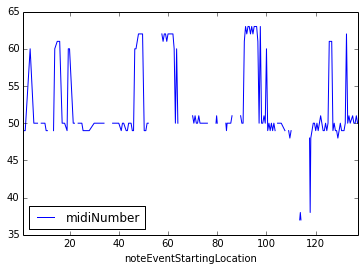

In [116]:
df2[1:200].plot(x='noteEventStartingLocation', y='midiNumber')


In [74]:
df2 = df.groupby(['noteEventStartingLocation'])